In [ ]:
##DEFINING FILES TO USE
tcga_metadata_file = '/Volumes/project2/yangili1/qhauck/splicing_PCA/pca_testing/tcga_sampling/tcga_v2_samples.tsv'
splicing_mutant_metadata_file = '/Volumes/project2/yangili1/qhauck/splicing_PCA/pca_testing/tcga_sampling/seiller_splicing_mutant_metadata.txt'

cryptic_vals_file = '/Volumes/project2/yangili1/qhauck/splicing_PCA/pca_testing/tcga_sampling/tcga_vs_sf_ko/250430_tcga_10_just_factors_of_interest.tsv'
full_vals_file = '~/grad_school/gene41600/final_project/down_tcga_50.tsv'

In [2]:
#loading in libraries
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float32)

In [ ]:
##READING IN METADATA
tcga_meta = pd.read_csv(tcga_metadata_file, sep = '\t')
cryptic_meta = pd.read_csv(splicing_mutant_metadata_file, sep = '\t')

/var/folders/_f/knv9t56d7vvd12b523hy0wnr0000gn/T/ipykernel_85916/2684326540.py:1: DtypeWarning: Columns (6,20,85,89,112,113,114,115,116,117,120,121,122,123,124,125,127,130,191,193,194,199,203,204,207,230,238,256,265,266,267,268,269,270,271,272,276,277,278,281,283,286,287,288,289,290,291,292,293,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,313,314,316,317,318,323,326,328,330,331,332,333,336,339,341,342,343,344,347,349,350,351,352,355,356,358,359,360,361,362,363,364,366,367,368,369,370,374,375,377,378,379,380,381,382,390,391,392,393,394,395,396,397,398,400,401,402,403,404,405,406,407,408,409,410,413,415,416,417,418,419,420,426,429,430,431,433,434,435,436,437,438,439,440,441,442,443,446,448,450,451,452,453,454,455,456,457,458,459,460,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,502,503,504,505,506,507,508,509,510,511,512,513,514,515,517,518,519,520,521,522,523,524,

In [ ]:
# READING IN LOADINGS TO CLASSIFY ON (DATA)
cryptic_vals = pd.read_csv(cryptic_vals_file, sep = '\t', engine = 'pyarrow')
full_vals = pd.read_csv(full_vals_file, sep = '\t', engine = 'pyarrow')

In [5]:
#pre-process cryptic metadata to match IDs across datasets
cryptic_individuals = cryptic_meta['Tumor_Sample_Barcode'].apply(
    lambda x: '-'.join(x.split('-')[:3])
)

def get_first_three_parts(sample):
    parts = sample.split('-')
    return f"{parts[0]}-{parts[1]}-{parts[2]}"

cryptic_individuals = cryptic_meta['Tumor_Sample_Barcode'].apply(get_first_three_parts)

cryptic_meta['gdc_cases.submitter_id'] = cryptic_meta['Tumor_Sample_Barcode'].apply(
    lambda x: '-'.join(x.split('-')[:3])
)

# Perform the left join with tcga_metadata
selected_columns = ['rail_id', 'gdc_cases.submitter_id']
cryptic_meta = cryptic_meta.merge(
    tcga_meta[selected_columns],
    on='gdc_cases.submitter_id',
    how='left'
)

In [42]:
#Pre-process data to get rid of columns with too many NAs and convert rail_id to string
min_non_na = len(cryptic_vals.columns) // 2

# Drop rows with fewer non-NA values than the threshold
cryptic_vals = cryptic_vals.dropna(thresh=min_non_na)
cryptic_vals['rail_id'] = cryptic_vals['rail_id'].astype(str)

full_vals = full_vals.dropna(thresh=min_non_na)
full_vals['rail_id'] = full_vals['rail_id'].astype(str)

In [43]:
# Create a list of the positions we're interested in
sf3b1_positions = ['625', '626', '666', '700', '740', '741']

# Filter cryptic_meta for sf3b1 mutations at specific positions
sf3b1_mutants = cryptic_meta[
    # Filter for srsf2 mutations at specific positions
    (cryptic_meta['Hugo_Symbol'] == 'SF3B1') & 
    # Convert Protein_Position to numeric and check if it's in our list
    (cryptic_meta['Protein_position'].isin(sf3b1_positions))
]

# Get just the rail_ids if you want them as a separate series/list
sf3b1_rail_ids = sf3b1_mutants['rail_id']

In [56]:
# Create a list of the positions we're interested in
srsf2_positions = ['95']

# Filter cryptic_meta for srsf2 mutations at specific positions
srsf2_mutants= cryptic_meta[
    # Filter for srsf2 mutations at specific positions
    (cryptic_meta['Hugo_Symbol'] == 'SRSF2') & 
    # Convert Protein_Position to numeric and check if it's in our list
    (cryptic_meta['Protein_position'].isin(srsf2_positions))
]

# Get just the rail_ids if you want them as a separate series/list
srsf2_rail_ids = srsf2_mutants['rail_id']

In [57]:
u2af1_positions = ['34']

# Filter cryptic_meta for u2af1 mutations at specific positions
u2af1_mutants= cryptic_meta[
    # Filter for u2af1 mutations at specific positions
    (cryptic_meta['Hugo_Symbol'] == 'U2AF1') & 
    # Convert Protein_Position to numeric and check if it's in our list
    (cryptic_meta['Protein_position'].isin(u2af1_positions))
]

# Get just the rail_ids if you want them as a separate series/list
u2af1_rail_ids = u2af1_mutants['rail_id']

In [228]:
# Filter cryptic_meta for rbm10 mutations at specific positions
rbm10_mutants= cryptic_meta[
    # Filter for rbm10 mutations at specific positions
    (cryptic_meta['Hugo_Symbol'] == 'RBM10')
]

# Get just the rail_ids if you want them as a separate series/list
rbm10_rail_ids = rbm10_mutants['rail_id']

In [351]:
mutant_rail_ids = sf3b1_rail_ids.dropna().astype(int).astype(str)
data_to_use = cryptic_vals

In [352]:
#PRE-PROCESSING DATA TO MATCH CANCER TYPES ACROSS MUTANT AND NON-MUTANT SAMPLES

import numpy as np
# Get cancer types for mutants
tcga_meta['rail_id'] = tcga_meta['rail_id'].astype(str)
mutant_cancer_types = tcga_meta[tcga_meta['rail_id'].isin(mutant_rail_ids)]['gdc_cases.project.project_id'].value_counts()
cancer_types = mutant_cancer_types.index.tolist()

# Calculate proportions of each cancer type
mutant_proportions = mutant_cancer_types / len(mutant_rail_ids)

# Get all non-SF3B1 mutant rail_ids
non_mutant_meta = tcga_meta[~tcga_meta['rail_id'].isin(mutant_rail_ids)]

# Initialize list to store selected rail_ids
selected_rail_ids = []

# For each cancer type, sample the same proportion as in SF3B1 mutants
for cancer_type, proportion in mutant_proportions.items():
    # Get rail_ids for this cancer type
    cancer_rail_ids = non_mutant_meta[non_mutant_meta['gdc_cases.project.project_id'] == cancer_type]['rail_id']
    
    # Calculate number to sample based on proportion
    n_to_sample = int(proportion * len(mutant_rail_ids))
    
    # Sample rail_ids
    if len(cancer_rail_ids) >= n_to_sample:
        sampled_ids = np.random.choice(cancer_rail_ids, size=n_to_sample, replace=False)
        selected_rail_ids.extend(sampled_ids)

# Convert to numpy array
selected_rail_ids = np.array(selected_rail_ids)

##Consolodating data corresponding to balanced set of mutant and non-mutant samples
matched_samples = data_to_use[data_to_use['rail_id'].isin(selected_rail_ids)]
even_split = pd.concat([matched_samples, data_to_use[data_to_use['rail_id'].isin(mutant_rail_ids)]], axis = 0)


In [355]:

# Convert rail_ids to labels 
labels = np.zeros(len(even_split))

mutant_rail_ids = mutant_rail_ids.dropna()
mutant_rail_ids = mutant_rail_ids.astype(int).astype(str)

# Make sure cryptic_vals rail_ids are strings
even_split['rail_id'] = even_split['rail_id'].astype(str)

labels[even_split['rail_id'].isin(mutant_rail_ids)] = 1

# Get features (all columns except rail_id)
features = even_split.drop('rail_id', axis=1).values

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled = np.nan_to_num(features_scaled, nan=0.0, posinf=0.0, neginf=0.0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)


In [356]:
#DEFINING MODEL, SIMPLE MLP
class MLP(nn.Module):
    def __init__(self, input_dim=len(data_to_use.columns) - 1, hidden_dims=[512, 256, 128, 64], dropout_rate=0.4):
        super(MLP, self).__init__()
        
        layers = []
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer - removed Sigmoid here
        layers.append(nn.Linear(hidden_dims[-1], 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
    
model = MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Epoch 1/100 - Train Loss: 0.6968 - Val Loss: 0.6876
Epoch 2/100 - Train Loss: 0.6310 - Val Loss: 0.6817
Epoch 3/100 - Train Loss: 0.6076 - Val Loss: 0.6794
Epoch 4/100 - Train Loss: 0.6032 - Val Loss: 0.6753
Epoch 5/100 - Train Loss: 0.5427 - Val Loss: 0.6693
Epoch 6/100 - Train Loss: 0.5152 - Val Loss: 0.6622
Epoch 7/100 - Train Loss: 0.4609 - Val Loss: 0.6509
Epoch 8/100 - Train Loss: 0.4429 - Val Loss: 0.6374
Epoch 9/100 - Train Loss: 0.3812 - Val Loss: 0.6187
Epoch 10/100 - Train Loss: 0.3469 - Val Loss: 0.5992
Epoch 11/100 - Train Loss: 0.3010 - Val Loss: 0.5788
Epoch 12/100 - Train Loss: 0.2811 - Val Loss: 0.5592
Epoch 13/100 - Train Loss: 0.2744 - Val Loss: 0.5372
Epoch 14/100 - Train Loss: 0.2382 - Val Loss: 0.5233
Epoch 15/100 - Train Loss: 0.2020 - Val Loss: 0.5091
Epoch 16/100 - Train Loss: 0.1950 - Val Loss: 0.4974
Epoch 17/100 - Train Loss: 0.1830 - Val Loss: 0.4864
Epoch 18/100 - Train Loss: 0.1855 - Val Loss: 0.4741
Epoch 19/100 - Train Loss: 0.1466 - Val Loss: 0.4654
Ep

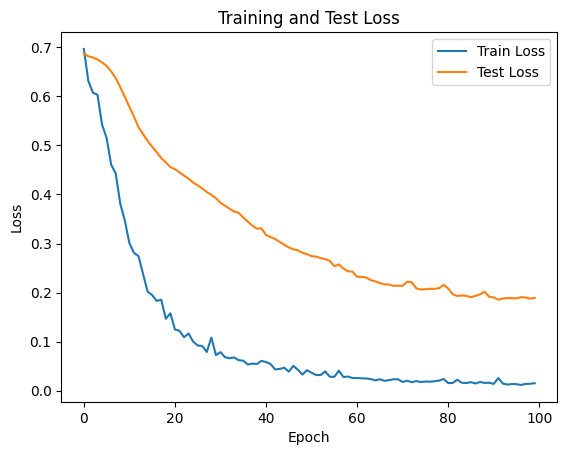

In [357]:
# Wrap the data in PyTorch Datasets and DataLoaders
class SimpleDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)  # BCE expects (N, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SimpleDataset(X_train, y_train)
test_dataset = SimpleDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Training loop
n_epochs = 100
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)
    
    epoch_val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)
    scheduler.step(epoch_val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")

# Optional: plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss")
plt.show()


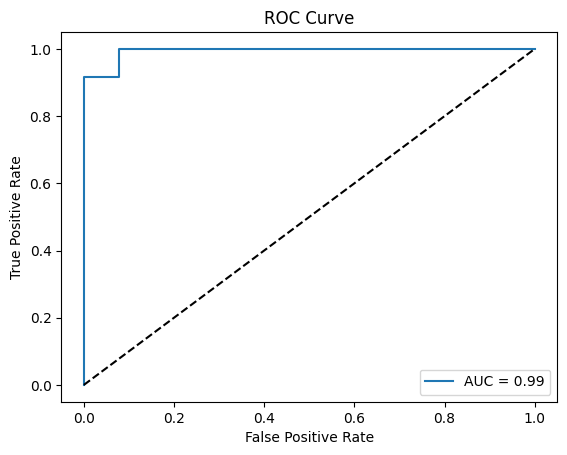

In [ ]:
#PLOTTING SOME METRICS FOR CLASSIFICATION
from sklearn.metrics import roc_curve, auc

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
        all_preds.extend(probs.squeeze().numpy())
        all_labels.extend(y_batch.squeeze().numpy())

fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


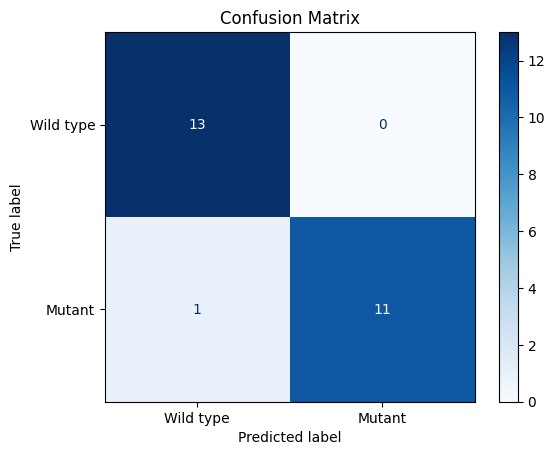

In [359]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert probabilities to binary predictions using 0.5 threshold
pred_labels = [1 if p >= 0.5 else 0 for p in all_preds]

cm = confusion_matrix(all_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Wild type", "Mutant"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

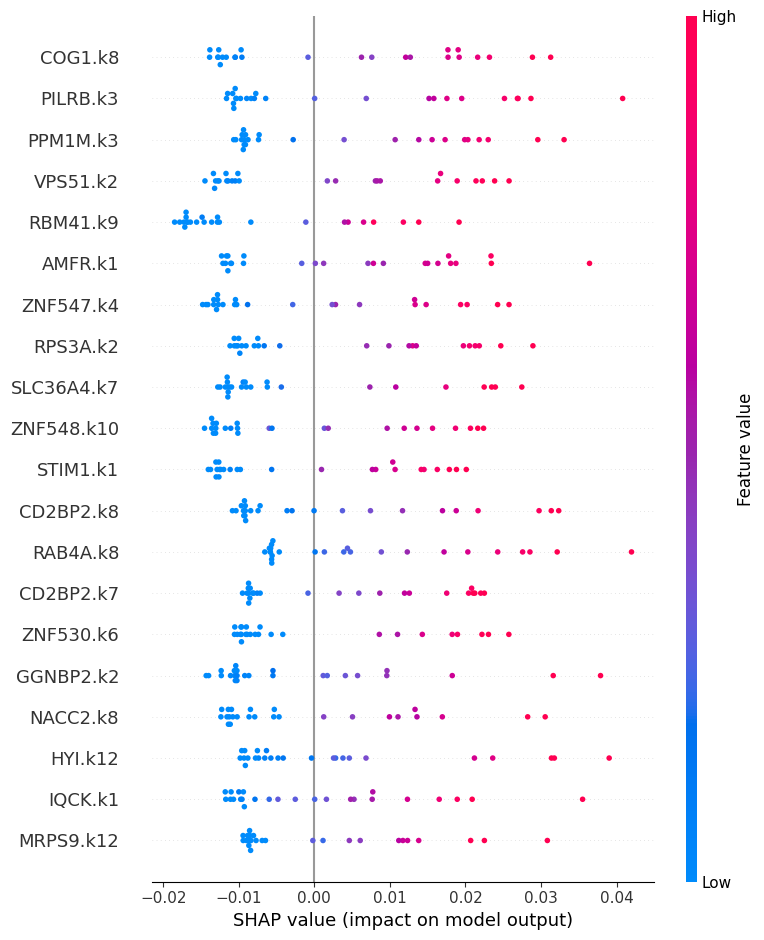

In [ ]:
# Install SHAP if needed
# !pip install shap  

import shap
import numpy as np
import torch

# Ensure model is in eval mode
model.eval()

# Define feature names
feature_names = even_split.drop('rail_id', axis=1).columns.tolist()

# Create background and sample input tensors
background = torch.tensor(X_train[np.random.choice(X_train.shape[0], 15, replace=False)], dtype=torch.float32)
sample_inputs = torch.tensor(X_test[:50], dtype=torch.float32)

# Create SHAP explainer
explainer = shap.DeepExplainer(model, background)

# Get SHAP values (only one output for binary classification)
shap_values = explainer.shap_values(sample_inputs)

shap.summary_plot(shap_values.squeeze(), sample_inputs.numpy(), feature_names = feature_names)


In [ ]:
## Further Shapley Value Analysis
mean_abs_shap = np.abs(shap_values.squeeze()).mean(axis=0)

sorted_idx = np.argsort(mean_abs_shap)[::-1]

sorted_shap_values = shap_values.squeeze()[:, sorted_idx]
sorted_sample_inputs = sample_inputs.numpy()[:, sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]


In [402]:
top_features = sorted_feature_names[0:50]
top_genes = [x.split('.')[0] for x in top_features]
top_genes = set(top_genes)

In [403]:
sf3b1_de_res = pd.read_csv('~/grad_school/gene41600/final_project/uvm_de_junction_results.csv')

In [404]:
ds_genes=set(sf3b1_de_res['Gene'])

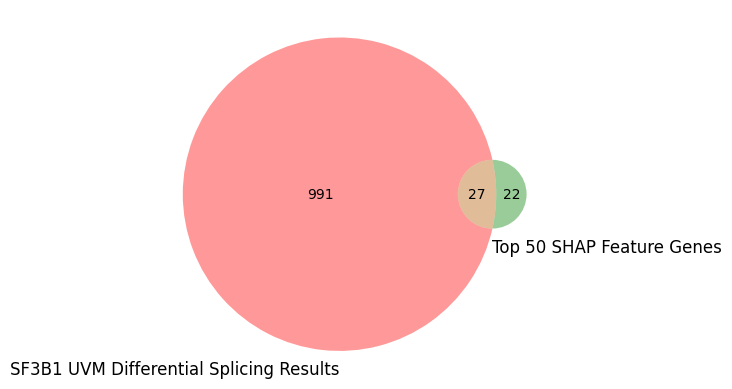

In [419]:
from matplotlib_venn import venn2


# Create the Venn diagram
venn2([ds_genes, top_genes], set_labels=('SF3B1 UVM Differential Splicing Results', 'Top 50 SHAP Feature Genes'))

# Display the plot
plt.show()


In [416]:
ds_genes & top_genes

{'AMFR',
 'COG1',
 'EFEMP2',
 'EIF2S3',
 'GGNBP2',
 'GPX1',
 'HYI',
 'IQCK',
 'KIFC2',
 'LYRM9',
 'MRPS9',
 'NACC2',
 'NFYA',
 'NONO',
 'PEF1',
 'PILRB',
 'PPM1M',
 'PRICKLE3',
 'PTDSS2',
 'RAB4A',
 'RNPEPL1',
 'SHPK',
 'SLC36A4',
 'SMOX',
 'STIM1',
 'TRIM3',
 'VPS51'}

In [418]:
sorted_feature_names[0:50]

['COG1.k8',
 'PILRB.k3',
 'PPM1M.k3',
 'VPS51.k2',
 'RBM41.k9',
 'AMFR.k1',
 'ZNF547.k4',
 'RPS3A.k2',
 'SLC36A4.k7',
 'ZNF548.k10',
 'STIM1.k1',
 'CD2BP2.k8',
 'RAB4A.k8',
 'CD2BP2.k7',
 'ZNF530.k6',
 'GGNBP2.k2',
 'NACC2.k8',
 'HYI.k12',
 'IQCK.k1',
 'MRPS9.k12',
 'TRIM3.k2',
 'EIF2S3.k4',
 'KIFC2.k2',
 'MAPK15.k14',
 'RNPEPL1.k1',
 'NFYA.k15',
 'IFI30.k2',
 'NONO.k2',
 'GPX1.k10',
 'LYRM9.k13',
 'MED21.k6',
 'PEF1.k2',
 'NENF.k10',
 'PRICKLE3.k14',
 'COPS2.k13',
 'RDH10.k9',
 'GNLY.k15',
 'SDC3.k3',
 'SMOX.k8',
 'PTDSS2.k5',
 'SLC25A33.k16',
 'SHPK.k2',
 'ST6GAL1.k2',
 'TYW3.k10',
 'EFEMP2.k7',
 'MANEAL.k5',
 'PTGIS.k3',
 'ZNF576.k4',
 'MZB1.k9',
 'STIM2.k5']